In [36]:
import matplotlib.pyplot as plt
from nltk import tokenize
import pandas as pd
import PyPDF2
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import numpy as np
import seaborn as sns
import umap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import pipeline

import requests
import json
from pathlib import Path

In [2]:
def split_to_sentences(text, length_threshold=25):
    """Tokenize text to sentences, clean it from line splits and short sentences"""
    sentences = []
    
    for sentence in tokenize.sent_tokenize(text):
        if len(sentence) > length_threshold:
            sentences.append(sentence.replace("\n", " "))

    return sentences

In [3]:
DATA_DIR = Path("data/sc_papers/")
DATA_DIR.mkdir(exist_ok=True)

In [4]:
papers_df = pd.read_csv("data/01_manual_extraction_2023_02_21.csv")
papers_df.head()

,Shorthand,DOI,Number individuals,N_individulas sentence,Organism,Reported cells total,Tissue,Contrasts,excluded,Authors,...,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID
0,Cauli et al PNAS,10.1073/pnas.97.11.6144,NaN,NaN,Rat,85,Brain,NaN,NaN,"B. Cauli, J. T. Porter, K. Tsuzuki, B. Lambole...",...,21-27 days,3.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
1,Malnic et al Cell,10.1016/S0092-8674(00)80581-4,NaN,NaN,Mouse,18,Brain,NaN,NaN,"Bettina Malnic, Junzo Hirono, Takaaki Sato, Li...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,2.0,This prompted us to harvest OSNs and OPCs from...,"Human, Mouse",37,Brain,NaN,NaN,"Ian Tietjen, Jason M. Rihel, Yanxiang Cao, Geo...",...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,"Manual, LCM",NaN
3,Gallopin et al CCortex,10.1093/cercor/bhj081,NaN,NaN,Rat,157,Brain,NaN,NaN,"Thierry Gallopin, Hélène Geoffroy, Jean Rossie...",...,21-27 days,4.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
4,Kurimoto et al NAR,10.1093/nar/gkl050,NaN,NaN,Mouse,20,ICM,NaN,NaN,K. Kurimoto,...,E3.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
is_included = (papers_df["Tissue"] != "Culture") & \
              (papers_df["Tissue"] != "Organoid") & \
              (papers_df["Organism"].str.contains("Human")) & \
              (papers_df["excluded"].isna())

In [6]:
print("Before exclusion:", papers_df.shape)
papers_df = papers_df.loc[is_included, :]
print("After exclusion:", papers_df.shape)

Before exclusion: (1820, 30)
After exclusion: (677, 30)


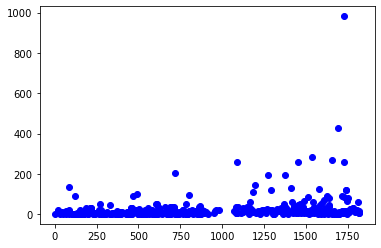

In [7]:
plt.plot(papers_df["Number individuals"], "bo")

# Download PDF files with papers

In [ ]:
OA_URL = "https://api.openaccessbutton.org/find?id={doi}"

checked_dois = set()

In [ ]:
for _, row in papers_df.iterrows():
    doi = row["DOI"]
    
    paper_dir = DATA_DIR / row["Shorthand"]
    
    if (paper_dir / "paper.pdf").is_file():
        checked_dois.add(doi)

In [ ]:
len(checked_dois)

In [ ]:
def get_paper_by_doi(doi):
    try:
        doi_response = requests.get(OA_URL.format(doi=doi))
    except BaseException:
        print("Failed to get paper by doi")
        return None
        
    paper_info = json.loads(doi_response.text)
    
    if "url" not in paper_info:
        print("URL not found, skipping")
        return None

    return requests.get(paper_info["url"])

In [ ]:
for _, row in papers_df.iterrows():
    doi = row["DOI"]
    print("Working with", doi, end="\t")
    
    if doi in checked_dois:
        print("already processed, skipping")
        continue

    checked_dois.add(doi)
    
    paper_response = get_paper_by_doi(doi)
    if paper_response is None:
        continue
        
    if len(paper_response.content) < 2000:
        print("content is too short, trying biorxiv", end="\t")
        
        biorxiv_doi = row["bioRxiv DOI"]
        if not pd.isna(biorxiv_doi) and not biorxiv_doi == "-":
            paper_response = get_paper_by_doi(biorxiv_doi)
            if paper_response is None or len(paper_response.content) < 2000:
                print("failed, skipping")
                continue
    
    paper_dir = DATA_DIR / row["Shorthand"]
    paper_dir.mkdir()

    with open(paper_dir / "paper.pdf", "wb") as f:
        f.write(paper_response.content)

    print("success")   

# Convert PDFs to txt files

In [ ]:
paper_dir

In [ ]:
for paper_dir in tqdm(list(DATA_DIR.glob("*"))):
    
    pdf_file = paper_dir / "paper.pdf"
    txt_file = paper_dir / "text.txt"
    
    if not pdf_file.is_file() or txt_file.is_file():
        continue

    with open(pdf_file, "rb") as f:
        pdf_reader = PyPDF2.PdfReader(f)

        with open(txt_file, "w") as g:
            for page in pdf_reader.pages:
                text = page.extract_text()
                g.write(text)

# Save manually labeled data

Data schema is the following:

```
- <paper_dir>/paper_info.txt
{
    doi: "10.1016/j.cell.2017.04.014",
    n_patients: 32,
    label_type: "manual"
    sentences: [
        "Patient Clinical Characteristics Samples were collected from 32 patients, 28 of whom were diagnosed with adenocarcinoma and thus included in the study (Table S1)."
    ]
}
```

In [8]:
positive_examples = []

for _, row in papers_df.iterrows():
    doi = row["DOI"]
    print("Working with", doi, end="\t")

    paper_dir = DATA_DIR / row["Shorthand"]
    txt_file = paper_dir / "text.txt"
    sentence = row["N_individulas sentence"]
    info_file = paper_dir / "paper_info.json"
    
    if not txt_file.is_file() or not paper_dir.is_dir() or pd.isna(sentence) or info_file.is_file():
        print("skipping")
        continue
    
    file_info = {
        "doi": doi,
         "n_patients": row["Number individuals"],
         "label_type": "manual",
         "sentences": [sentence],
    }
    
    positive_examples.append(sentence)
    
    with open(info_file, "w") as f:
        f.write(json.dumps(file_info))
        print("success")

Working with 10.1016/S0896-6273(03)00229-0	skipping
Working with 10.1038/nature12364	skipping
Working with 10.1038/nbt.2859	skipping
Working with 10.1126/science.1254257	skipping
Working with 10.1038/nbt.2967	skipping
Working with 10.1126/science.1258367	skipping
Working with 10.1073/pnas.1507125112	skipping
Working with 10.1016/j.cell.2015.05.015	skipping
Working with 10.1186/s13059-015-0692-3	skipping
Working with 10.1038/ncomms9207	skipping
Working with 10.1126/science.aab0917	skipping
Working with 10.1016/j.cell.2015.09.004	skipping
Working with 10.15252/embr.201540946	skipping
Working with 10.1038/icb.2016.16	skipping
Working with 10.1093/humrep/dew008	skipping
Working with 10.1038/ni.3368	skipping
Working with 10.1016/j.cell.2016.03.023	skipping
Working with 10.1186/s13059-016-0932-1	skipping
Working with 10.1186/s13059-016-0945-9	skipping
Working with 10.1126/science.aaf1204	skipping
Working with 10.2337/db16-0405	skipping
Working with 10.1038/nature19328	skipping
Working with 1

In [9]:
positive_examples

[]

In [10]:
len(positive_examples)

0

# Generate dataset

In [8]:
positive_examples = papers_df["N_individulas sentence"].dropna().tolist()

In [9]:
NEGATIVE_SENTENCES_PERCENT = 0.1

negative_sentences = []
n_sentences_per_paper = []

for _, row in papers_df.iterrows():
    doi = row["DOI"]

    paper_dir = DATA_DIR / row["Shorthand"]
    txt_file = paper_dir / "text.txt"
    
    if not txt_file.is_file() or not paper_dir.is_dir():
        continue
        
    with open(txt_file, "r") as f:
        text = f.read()
        
    sentences = split_to_sentences(text)
    n_sentences_per_paper.append(len(sentences))
    sentences_to_take = int(len(sentences) * NEGATIVE_SENTENCES_PERCENT)
    
    random_sentences = np.random.choice(sentences, size=sentences_to_take)
    negative_sentences.extend(random_sentences)
    
n_sentences_per_paper = np.array(n_sentences_per_paper)

<AxesSubplot:ylabel='Count'>

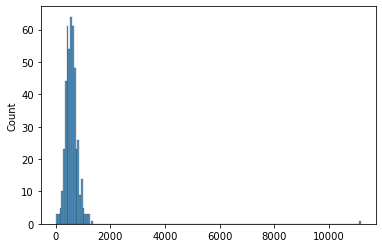

In [10]:
sns.histplot(n_sentences_per_paper)

In [11]:
np.median(n_sentences_per_paper)

562.5

In [12]:
len(negative_sentences)

27068

In [13]:
NEGATIVE_SUBSET_SIZE = 10000

sentences_encoder = SentenceTransformer("all-MiniLM-L6-v2")
positive_embeddings = sentences_encoder.encode(positive_examples)
negative_embeddings = sentences_encoder.encode(np.random.choice(negative_sentences, NEGATIVE_SUBSET_SIZE))

In [14]:
labels = np.zeros(len(positive_embeddings) + len(negative_embeddings))
labels[:len(positive_examples)] = 1

In [15]:
positive_embeddings.shape

(208, 384)

In [16]:
negative_embeddings.shape

(10000, 384)

In [17]:
embeddings = np.concatenate([positive_embeddings, negative_embeddings])

In [18]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df["label"] = labels
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,label
0,-0.149905,0.034499,0.006448,0.013295,0.021436,-0.073285,-0.016038,-0.029098,0.030068,0.027150,...,0.004006,0.013397,-0.100997,0.011662,0.026731,0.039014,-0.022877,0.020072,-0.002807,1.0
1,-0.013851,-0.057114,-0.007840,-0.039599,-0.081446,-0.003748,-0.068731,0.059235,0.012949,0.008579,...,0.061391,-0.014621,-0.039339,0.082275,0.019739,0.027435,-0.034375,0.056117,-0.034288,1.0
2,-0.013408,0.029738,-0.047513,-0.008485,-0.040417,-0.025945,0.024130,0.113915,-0.076896,0.017202,...,0.055509,0.038119,0.011553,0.006478,0.013213,0.067005,-0.052429,0.028130,0.039395,1.0
3,-0.018104,-0.005853,0.002173,-0.028846,-0.027600,-0.030690,0.001077,-0.055285,0.013246,-0.016770,...,0.032520,-0.006658,0.048440,0.077220,-0.039835,0.038257,0.062585,0.002125,-0.040183,1.0
4,-0.024165,-0.035901,0.031012,-0.027034,-0.012985,0.007257,-0.048680,0.020998,0.032342,-0.023546,...,0.102684,-0.060694,0.012417,0.047035,-0.016857,0.032060,-0.009616,-0.004141,-0.073214,1.0


In [19]:
reducer = umap.UMAP()

In [20]:
umap_embedding = reducer.fit_transform(embeddings)

<AxesSubplot:>

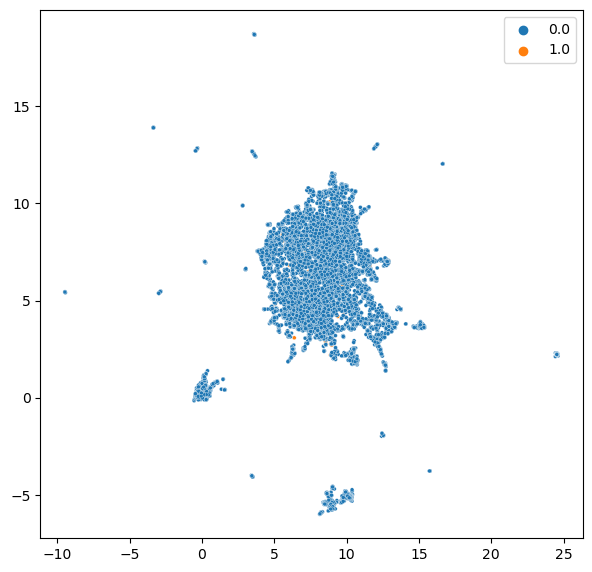

In [22]:
plt.figure(figsize=(7, 7), dpi=100)
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=labels, s=8)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=2/3)

In [24]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [25]:
print(classification_report(y_train, log_reg.predict(X_train)))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      6671
         1.0       0.27      1.00      0.43       134

    accuracy                           0.95      6805
   macro avg       0.64      0.97      0.70      6805
weighted avg       0.99      0.95      0.96      6805



In [26]:
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      3329
         1.0       0.23      0.88      0.36        74

    accuracy                           0.93      3403
   macro avg       0.61      0.91      0.66      3403
weighted avg       0.98      0.93      0.95      3403



In [27]:
test_probs = log_reg.predict_proba(X_test)

(0.0, 1.0)

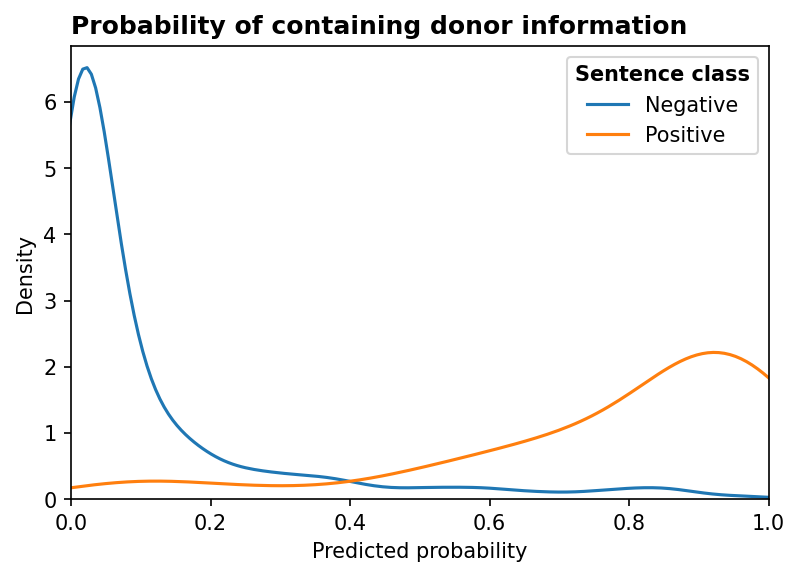

In [173]:
plt.figure(figsize=(6, 4), dpi=150)

sns.kdeplot(test_probs[y_test == 0, 1], label="Negative")
sns.kdeplot(test_probs[y_test == 1, 1], label="Positive")
plt.legend(title="Sentence class", title_fontproperties={"weight": "bold"})
plt.xlabel("Predicted probability")
plt.title("Probability of containing donor information", fontweight="bold", loc="left")
plt.xlim(0, 1)

# Search sentences

## With classifier

Fit the model on the whole data

In [29]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(embeddings, labels)

LogisticRegression(class_weight='balanced')

In [31]:
SIMILARITY_THRESHOLD = 0.5

for _, row in papers_df.iterrows():
    doi = row["DOI"]

    sentence = row["N_individulas sentence"]
    paper_dir = DATA_DIR / row["Shorthand"]
    txt_file = paper_dir / "text.txt"
    summary_file = paper_dir / "filtered_text.txt"
    
    if not txt_file.is_file() or not paper_dir.is_dir():
        continue
        
    with open(txt_file, "r") as f:
        text = f.read()
        
        
    sentences = np.array(split_to_sentences(text))
    sentence_embeddings = sentences_encoder.encode(sentences)
    probs = log_reg.predict_proba(sentence_embeddings)[:, 1]

    good_sentences = sentences[probs > SIMILARITY_THRESHOLD]
    if good_sentences:
        with open(summary_file, "w") as f:
            # Write sentences with high probability of contatining info to the file
            for sentence in good_sentences:
                f.write(sentence)
                f.write("\n")

# Run question answering model

Model: https://huggingface.co/distilbert-base-cased-distilled-squad?

In [42]:
context = "\n".join(sentences[probs > SIMILARITY_THRESHOLD])
print(context)

Ex vivo tissue perturbations coupled to single cell RNA-seq reveal multi-lineage cell circuit dynamics in human lung fibrogenesis Niklas J. Lang1,+, Janine Gote-Schniering1,+, Diana Porras-Gonzalez1, Lin Yang1, Laurens J.
Using micro-CT staged patient tissues, we characterized the appearance and interaction of myofibroblasts, an ectopic endothelial cell state and basaloid epithelial cells in the thickened alveolar septum of early-stage lung fibrosis.
Our work provides an experimental framework for perturbational single cell genomics directly in human lung tissue that enables analysis of tissue homeostasis, regeneration and pathology.
Recent single cell RNA sequencing (scRNA-seq) studies of PF patient cohorts8–12have led to the molecular description of fibrosis-specific cell states, including the KR17+/KRT5- basaloid epithelial cells, as well as several novel disease-associated endothelial, stromal and immune cell states.
After six days, we performed single-cell RNA sequencing (scRNA-se

In [45]:
question_answerer = pipeline("question-answering", model="krinal214/zero_shot")

# context = r"""
# Extractive Question Answering is the task of extracting an answer from a text given a question. An example     of a
# question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
# a model on a SQuAD task, you may leverage the examples/pytorch/question-answering/run_squad.py script.
# """

result = question_answerer(question="How many donors (patients, individuals, samples) were analyzed in this study?", context=context)
print(
    f"Answer: '{result['answer']}', "
    f"score: {round(result['score'], 4)}, "
    f"start: {result['start']}, "
    f"end: {result['end']}"
)


Answer: '63,581', score: 0.2206, start: 1072, end: 1078


In [46]:
result

{'score': 0.2205921858549118, 'start': 1072, 'end': 1078, 'answer': '63,581'}

## Using OpenAI models

In [49]:
import openai

In [73]:
openai.api_key = "sk-..."

In [1]:
SYSTEM_PROMPT = "You are helping to extract the data from scientific papers. Give short answer " + \
                "and the source sentence, from which you extracted the information"
QUESTION = "\nFor how many donors (patients, individuals) were single-cell RNA sequencing data " + \
           "analyzed in this study?"

In [2]:
SYSTEM_PROMPT

'You are helping to extract the data from scientific papers. Give short answer and the source sentence, from which you extracted the information'

In [3]:
QUESTION

'\nFor how many donors (patients, individuals) were single-cell RNA sequencing data analyzed in this study?'

In [71]:
# create a completion
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": context + QUESTION}
    ])
print(completion.choices[0].message.content)

The study analyzed single-cell RNA sequencing data from two tissue donors for the ex vivo human precision-cut lung slice (hPCLS) model of lung fibrogenesis, and also integrated single-cell data from three independent pulmonary fibrosis patient cohorts (Chicago, Nashville, and Newhaven) into an integrated PF cell atlas consisting of 481,788 single-cells from healthy and fibrotic lung tissues (143 patients). The data was also extensively validated in a large number of additional donor samples using immunostainings, but the scRNA-seq data was derived from only two donor replicates.


In [72]:
completion

<OpenAIObject chat.completion id=chatcmpl-6pizdI7boqpH9tP7i7fPpZrxTbhl7 at 0x2903b38b0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "The study analyzed single-cell RNA sequencing data from two tissue donors for the ex vivo human precision-cut lung slice (hPCLS) model of lung fibrogenesis, and also integrated single-cell data from three independent pulmonary fibrosis patient cohorts (Chicago, Nashville, and Newhaven) into an integrated PF cell atlas consisting of 481,788 single-cells from healthy and fibrotic lung tissues (143 patients). The data was also extensively validated in a large number of additional donor samples using immunostainings, but the scRNA-seq data was derived from only two donor replicates.",
        "role": "assistant"
      }
    }
  ],
  "created": 1677785701,
  "id": "chatcmpl-6pizdI7boqpH9tP7i7fPpZrxTbhl7",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "com

Economics calculation

In [77]:
price = 0.002 # $ per 1000 tokens. Source: https://openai.com/pricing
thousand_tokens_per_question = 5  # Let's be pessimistic
n_quesions = papers_df.shape[0]  # Not exactly but let's be pessimistic again

round(price * thousand_tokens_per_question * n_quesions, 4)  #  <$7. Absolutely reasonable!

6.77

In [82]:
import time

In [93]:
len(context)

24469

In [101]:
k = 0
LENGTH_THRESHOLD = 15000

for _, row in papers_df.iterrows():
    doi = row["DOI"]
    paper_dir = DATA_DIR / row["Shorthand"]
    print("Working with", doi, k, "/", papers_df.shape[0], "done")        
    k += 1

    summary_file = paper_dir / "filtered_text.txt"
    answer_file = paper_dir / "chatgpt_answer.txt"
    
    if not paper_dir.is_dir() or not summary_file.is_file() or answer_file.is_file():
        continue
        
    with open(summary_file, "r") as f:
        context = f.read()
        
    if len(context) > LENGTH_THRESHOLD:
        context = context[:LENGTH_THRESHOLD]
    
    completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": context + QUESTION}
        ])
    
    if not completion.choices:
        continue
    
    answer = completion.choices[0].message.content
    
    with open(answer_file, "a") as f: 
        f.write(answer)

    time.sleep(30)  # Requests limit is 20/min

Working with 10.1016/S0896-6273(03)00229-0 0 / 677 done
Working with 10.1038/nature12364 1 / 677 done
Working with 10.1038/nbt.2859 2 / 677 done
Working with 10.1126/science.1254257 3 / 677 done
Working with 10.1038/nbt.2967 4 / 677 done
Working with 10.1126/science.1258367 5 / 677 done
Working with 10.1073/pnas.1507125112 6 / 677 done
Working with 10.1016/j.cell.2015.05.015 7 / 677 done
Working with 10.1186/s13059-015-0692-3 8 / 677 done
Working with 10.1038/ncomms9207 9 / 677 done
Working with 10.1126/science.aab0917 10 / 677 done
Working with 10.1016/j.cell.2015.09.004 11 / 677 done
Working with 10.15252/embr.201540946 12 / 677 done
Working with 10.1038/icb.2016.16 13 / 677 done
Working with 10.1093/humrep/dew008 14 / 677 done
Working with 10.1038/ni.3368 15 / 677 done
Working with 10.1016/j.cell.2016.03.023 16 / 677 done
Working with 10.1186/s13059-016-0932-1 17 / 677 done
Working with 10.1186/s13059-016-0945-9 18 / 677 done
Working with 10.1126/science.aaf1204 19 / 677 done
Workin

Working with 10.1111/bjh.16225 207 / 677 done
Working with 10.1182/blood.2019002301 208 / 677 done
Working with 10.1186/s13059-019-1830-0 209 / 677 done
Working with 10.1038/s41467-019-12464-3 210 / 677 done
Working with 10.1101/809731 211 / 677 done
Working with 10.1159/000503737 212 / 677 done
Working with 10.1016/j.cell.2019.09.035 213 / 677 done
Working with 10.1038/s41467-019-12780-8 214 / 677 done
Working with 10.1073/pnas.1914143116 215 / 677 done
Working with 10.1016/j.celrep.2019.10.024 216 / 677 done
Working with 10.1073/pnas.1907883116 217 / 677 done
Working with 10.1016/j.cell.2019.10.027 218 / 677 done
Working with 10.1038/s41593-019-0532-y 219 / 677 done
Working with 10.1038/s41590-019-0544-5 220 / 677 done
Working with 10.1084/jem.20191130 221 / 677 done
Working with 10.1002/pros.23929 222 / 677 done
Working with 10.1038/s41593-019-0539-4 223 / 677 done
Working with 10.1038/s41587-019-0332-7 224 / 677 done
Working with 10.1101/863332 225 / 677 done
Working with 10.1093/b

Working with 10.1186/s13073-020-00756-z 359 / 677 done
Working with 10.1038/s41587-020-0602-4 360 / 677 done
Working with 10.1016/j.cell.2020.06.001 361 / 677 done
Working with 10.1038/s41591-020-0939-8 362 / 677 done
Working with 10.1016/j.immuni.2020.06.002 363 / 677 done
Working with 10.1038/s41598-020-67730-y 364 / 677 done
Working with 10.1038/s41467-020-17186-5 365 / 677 done
Working with 10.1126/sciadv.aba1972 366 / 677 done
Working with 10.1126/sciadv.aba1983 367 / 677 done
Working with 10.1126/sciimmunol.abd1554 368 / 677 done
Working with 10.1084/jem.20200483 369 / 677 done
Working with 10.1016/j.cell.2020.06.038 370 / 677 done
Working with 10.1016/j.cell.2020.06.037 371 / 677 done
Working with 10.1126/science.aba5906 372 / 677 done
Working with 10.1038/s41590-020-0743-0 373 / 677 done
Working with 10.1073/pnas.2003900117 374 / 677 done
Working with 10.1016/j.cell.2020.08.001 375 / 677 done
Working with 10.1093/nsr/nwaa179 376 / 677 done
Working with 10.1007/s13238-020-00762-

Working with 10.1182/blood.2020009346 510 / 677 done
Working with 10.1101/2021.07.07.451374 511 / 677 done
Working with 10.1038/s41588-021-00894-z 512 / 677 done
Working with 10.1186/s13073-021-00922-x  513 / 677 done
Working with 10.1101/2021.07.14.452217 514 / 677 done
Working with 10.1242/dev.199711 515 / 677 done
Working with 10.1101/2021.07.19.452956 516 / 677 done
Working with 10.1101/2021.07.20.453090 517 / 677 done
Working with 10.1038/s41586-021-03752-4 518 / 677 done
Working with 10.15252/msb.20209833 519 / 677 done
Working with 10.1038/s41467-021-24730-4 520 / 677 done
Working with 10.1016/j.xcrm.2021.100353 521 / 677 done
Working with 10.1101/2021.07.28.454201 522 / 677 done
Working with 10.1002/ctm2.500 523 / 677 done
Working with 10.1038/s41592-021-01222-3 524 / 677 done
Working with 10.21203/rs.3.rs-745435/v1 525 / 677 done
Working with 10.1038/s41467-021-25101-9 526 / 677 done
Working with 10.1101/2021.08.09.455617 527 / 677 done
Working with 10.1038/s41598-021-94933-8 

Working with  10.1038/s41467-022-33052-y  663 / 677 done
Working with 10.1101/2022.09.20.508634 664 / 677 done
Working with 10.1038/s41592-022-01684-z 665 / 677 done
Working with 10.1101/2022.12.06.519403 666 / 677 done
Working with 10.1016/j.devcel.2022.11.013 667 / 677 done
Working with 10.1038/s41467-022-35297-z 668 / 677 done
Working with 10.1016/j.cell.2022.11.019 669 / 677 done
Working with 10.1101/2022.12.13.520231 670 / 677 done
Working with 10.1101/2022.12.11.519930 671 / 677 done
Working with 10.1101/2022.12.16.520801 672 / 677 done
Working with 10.1101/2022.12.19.521110 673 / 677 done
Working with 10.1038/s44161-022-00183-w 674 / 677 done
Working with 10.1038/s41467-022-35238-w 675 / 677 done
Working with 10.1101/2023.01.16.524219 676 / 677 done


# Read ChatGPT answers to the table

In [123]:
all_papers_df = pd.read_csv("data/01_manual_extraction_2023_02_21.csv")

In [129]:
answers = []

for _, row in all_papers_df.iterrows():
    doi = row["DOI"]
    paper_dir = DATA_DIR / row["Shorthand"]
    answer_file = paper_dir / "chatgpt_answer.txt"
    
    if not paper_dir.is_dir() or not answer_file.is_file():
        answer = ""
    else:
        with open(answer_file, "r") as f:
            answer = f.read()
        
    answers.append({"DOI": doi, "chatgpt_sentence": answer})

In [130]:
len(answers)

1820

In [131]:
chatgpt_df = pd.DataFrame(answers)

In [133]:
(chatgpt_df["DOI"] == all_papers_df["DOI"]).all()

True

In [136]:
all_papers_df["chatgpt_sentence"] = chatgpt_df["chatgpt_sentence"]

In [137]:
all_papers_df.to_excel("data/02_chatgpt_answers.xlsx")

# Check agreement between ChatGPT and manual annotation

In [139]:
df = pd.read_csv("data/03_manual_check.csv", index_col=0, decimal=",")
df

,Shorthand,DOI,Number individuals,N_individulas sentence,chatgpt_n_individuals_answer,chatgpt_sentence,Organism,Reported cells total,Tissue,Contrasts,...,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID
0,Cauli et al PNAS,10.1073/pnas.97.11.6144,NaN,NaN,NaN,NaN,Rat,85,Brain,NaN,...,21-27 days,3.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
1,Malnic et al Cell,10.1016/S0092-8674(00)80581-4,NaN,NaN,NaN,NaN,Mouse,18,Brain,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,2.0,This prompted us to harvest OSNs and OPCs from...,NaN,There is no specific information given in the ...,"Human, Mouse",37,Brain,NaN,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,"Manual, LCM",NaN
3,Gallopin et al CCortex,10.1093/cercor/bhj081,NaN,NaN,NaN,NaN,Rat,157,Brain,NaN,...,21-27 days,4.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
4,Kurimoto et al NAR,10.1093/nar/gkl050,NaN,NaN,NaN,NaN,Mouse,20,ICM,NaN,...,E3.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,O'Brien et al bioRxiv,10.1101/2022.12.20.521287,NaN,NaN,NaN,NaN,Mouse,"16,434",Stomach,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,Knight-Schrijver et al NCR,10.1038/s44161-022-00183-w,7.0,NaN,NaN,Single-cell RNA sequencing data were analyzed ...,Human,"60,668",Heart,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817,Tietscher et al NCommunications,10.1038/s41467-022-35238-w,14.0,NaN,NaN,Single-cell RNA sequencing data was analyzed f...,Human,"120,000",Tumor,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,de Jonghe et al bioRxiv,10.1101/2023.01.12.523500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
df["answers_agreement"] = (df["Number individuals"] == df["chatgpt_n_individuals_answer"])
chatgpt_annotated = df["chatgpt_n_individuals_answer"].notna()
manually_annotated = df["Number individuals"].notna() & df["N_individulas sentence"].notna()

print(df.loc[chatgpt_annotated & manually_annotated, ].shape[0], "annotated papers by both methods")
print(df.loc[chatgpt_annotated & manually_annotated, "answers_agreement"].sum(), "agreed")
print(df.loc[chatgpt_annotated & manually_annotated, "answers_agreement"].mean(), "% agreed")

119 annotated papers by both methods
90 agreed
0.7563025210084033 % agreed


In [158]:
df["answers_agreement"] = df["answers_agreement"].map({False: "Different answers", True: "Same answer"})

Text(0, 0.5, 'ChatGPT answer')

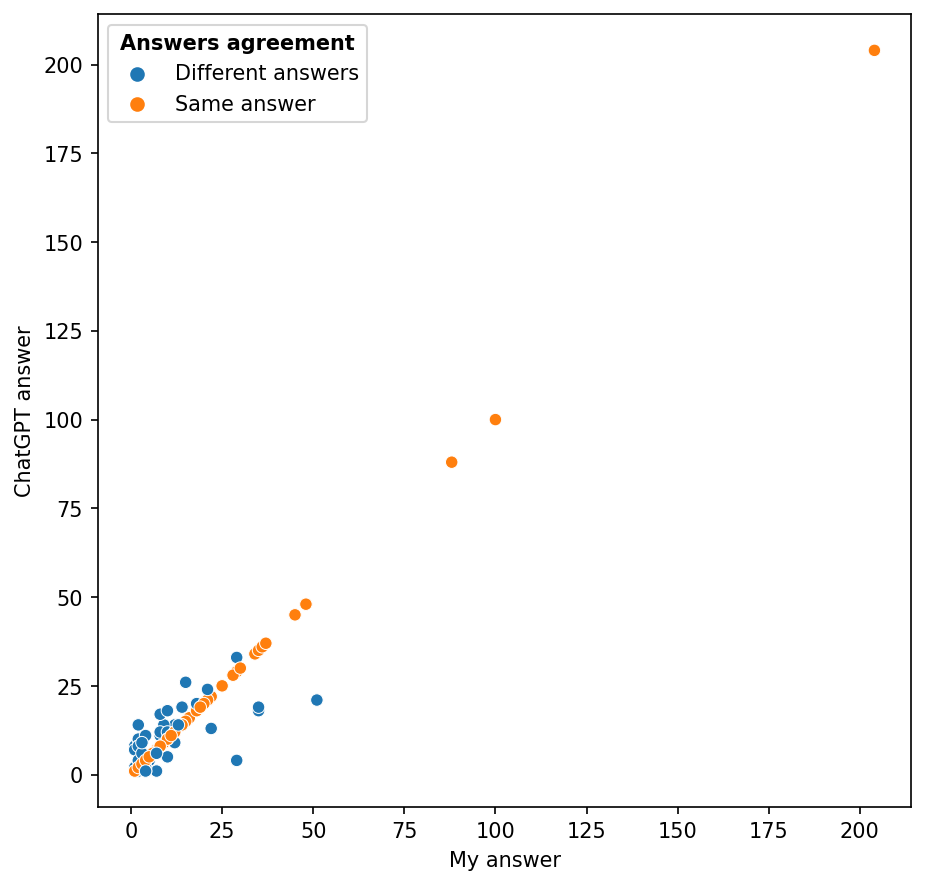

In [162]:
plt.figure(figsize=(7, 7), dpi=150)


sns.scatterplot(df, x="Number individuals", y="chatgpt_n_individuals_answer", hue="answers_agreement")
plt.legend(title="Answers agreement", title_fontproperties={"weight": "bold"})
plt.xlabel("My answer")
plt.ylabel("ChatGPT answer")

# Analyze inconsistencies after manual rechecking

In [147]:
rechecked_df = pd.read_csv("data/04_rechecked.csv", index_col=0)
rechecked_df.head()

,Shorthand,DOI,rechecked_n_individuals,overlap,Number individuals,N_individulas sentence,chatgpt_n_individuals_answer,chatgpt_sentence,Organism,Reported cells total,...,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID
0,Cauli et al PNAS,10.1073/pnas.97.11.6144,NaN,NaN,NaN,NaN,NaN,NaN,Rat,85,...,21-27 days,3.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
1,Malnic et al Cell,10.1016/S0092-8674(00)80581-4,NaN,NaN,NaN,NaN,NaN,NaN,Mouse,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,NaN,False,2.0,This prompted us to harvest OSNs and OPCs from...,NaN,There is no specific information given in the ...,"Human, Mouse",37,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,"Manual, LCM",NaN
3,Gallopin et al CCortex,10.1093/cercor/bhj081,NaN,NaN,NaN,NaN,NaN,NaN,Rat,157,...,21-27 days,4.0,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN
4,Kurimoto et al NAR,10.1093/nar/gkl050,NaN,NaN,NaN,NaN,NaN,NaN,Mouse,20,...,E3.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
rechecked_df["answers_agreement"] = (rechecked_df["Number individuals"] == \
                                     rechecked_df["chatgpt_n_individuals_answer"])
chatgpt_annotated = rechecked_df["chatgpt_n_individuals_answer"].notna()
manually_annotated = rechecked_df["Number individuals"].notna() & rechecked_df["N_individulas sentence"].notna()

print(rechecked_df.loc[chatgpt_annotated & manually_annotated, ].shape[0], "annotated papers by both methods")
print(rechecked_df.loc[chatgpt_annotated & manually_annotated, "answers_agreement"].sum(), "agreed")
print(rechecked_df.loc[chatgpt_annotated & manually_annotated, "answers_agreement"].mean(), "% agreed")

119 annotated papers by both methods
91 agreed
0.7647058823529411 % agreed


In [154]:
def percent(part, whole, round_digits=2):
    return round(100 * part / whole, round_digits)


rechecked_examples = rechecked_df.loc[rechecked_df["rechecked_n_individuals"].notna(), :]
n_rechecks = rechecked_examples.shape[0]

i_was_right = (rechecked_examples["rechecked_n_individuals"] == rechecked_examples["Number individuals"]).sum()
chatgpt_was_right = (rechecked_examples["rechecked_n_individuals"] == \
                     rechecked_examples["chatgpt_n_individuals_answer"]).sum()

print(n_rechecks, "inconsistencies checked")
print(i_was_right, "manual annotation results confirmed,", percent(i_was_right, n_rechecks), "%")
print(chatgpt_was_right, "chatgpt annotation results confirmed,", percent(chatgpt_was_right, n_rechecks), "%")
print(n_rechecks - i_was_right - chatgpt_was_right, "cases where both results were wrong",
      percent(n_rechecks - i_was_right - chatgpt_was_right, n_rechecks), "%")

28 inconsistencies checked
13 manual annotation results confirmed, 46.43 %
12 chatgpt annotation results confirmed, 42.86 %
3 cases where both results were wrong 10.71 %


In [163]:
28 / 119

0.23529411764705882

In [153]:
rechecked_examples

,Shorthand,DOI,rechecked_n_individuals,overlap,Number individuals,N_individulas sentence,chatgpt_n_individuals_answer,chatgpt_sentence,Organism,Reported cells total,...,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID,answers_agreement
68,Guo et al Cell,10.1016/j.cell.2015.05.015,15.0,False,15.0,"In total, we obtained RNA deep-sequencing data...",26.0,Single-cell RNA sequencing data was analyzed f...,Human,364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
70,Kim et al GBiology,10.1186/s13059-015-0692-3,2.0,False,2.0,Participants in this study gave written inform...,1.0,Single-cell RNA sequencing data was analyzed f...,Human,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
87,Miyamoto et al Science,10.1126/science.aab0917,13.0,False,22.0,A total of 221 single candidate prostate CTCs ...,13.0,Single-cell RNA sequencing data were analyzed ...,Human,157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
187,Zheng et al NComm,10.1038/ncomms14049,5.0,False,29.0,To demonstrate the system’s technical perform...,4.0,Single-cell RNA sequencing data were analyzed ...,"Human, Mouse","250,000",...,NaN,Yes,NaN,NaN,Yes,Yes,NaN,Nanodroplet dilution,NaN,False
211,Villani et al Science,10.1126/science.aah4573,14.0,False,12.0,"For monocytes, a total of four plates were pro...",14.0,Single-cell RNA sequencing data were analyzed ...,Human,"3,359",...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
218,Der et al JCIInsight,10.1172/jci.insight.93009,29.0,False,29.0,A total of 5 and 12 skin samples from healthy...,33.0,Single-cell RNA sequencing data was analyzed f...,Human,899,...,6.0,NaN,No,No,Yes,Yes,NaN,NaN,NaN,False
234,Wang et al CCell,10.1016/j.ccell.2017.06.003,1.0,False,1.0,"From a single patient, we obtained two initial...",8.0,Single-cell RNA sequencing data were analyzed ...,Human,133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
254,Guo et al CSC,10.1016/j.stem.2017.09.003,5.0,False,5.0,We isolated SSEA4+ hSSCs and c-KIT+ spermatogo...,4.0,Single-cell RNA sequencing data was analyzed f...,Human,175,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
344,Zirkel et al MCell,10.1016/j.molcel.2018.03.030,2.0,False,2.0,Freshly-frozen early- (p. 4) and late-passage ...,10.0,Single-cell RNA sequencing was analyzed from 2...,Human,"13,602",...,4.0,Yes,Yes,No,Yes,Yes,NaN,NaN,NaN,False
386,Liu et al CResearch,10.1038/s41422-018-0066-y,8.0,False,2.0,Here we performed single-cell RNA sequencing ...,8.0,Single-cell RNA sequencing data was analyzed f...,Human,"1,567",...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


## Search sentences by cosine similarity of embeddings to positive examples

In [95]:
SIMILARITY_THRESHOLD = 0.2

for _, row in papers_df.iterrows():
    doi = row["DOI"]
    print("Working with", row["Shorthand"])
    print("-" * 50)

    sentence = row["N_individulas sentence"]
    paper_dir = DATA_DIR / row["Shorthand"]
    txt_file = paper_dir / "text.txt"
    
    if not txt_file.is_file() or not paper_dir.is_dir():
        print(txt_file.is_file(), paper_dir.is_dir(), pd.isna(sentence), "skipping", sep="\t")
        print()
        continue
        
    with open(txt_file, "r") as f:
        text = f.read()
        
    sentences = np.array(split_to_sentences(text))
    sentence_embeddings = model.encode(sentences)
    distances_to_positives = np.zeros(shape=(len(sentences), len(positive_examples)))
    
    for i, embedding in enumerate(sentence_embeddings):
        for j, positive_embedding in enumerate(positive_examples_embeddings):
            distances_to_positives[i, j] = cosine(positive_embedding, embedding)
            
    top_similarities = distances_to_positives.min(axis=1)
    matches = sentences[top_similarities < 0.2]
    
    print("sentence:", sentence)
    print("-" * 50)
    
    for distance, text_sentence in zip(top_similarities[top_similarities < 0.2], matches):
        print(round(distance, 5), text_sentence, sep="\t")
        
    print()

Working with Tietjen et al Neuron
--------------------------------------------------
sentence: This prompted us to harvest OSNs and OPCs from adult and embryonic day 15 (E15) MOE, respectively, to increase the probability of successfully isolating multiple representatives of each cell type
--------------------------------------------------
0.18131	This prompted us to harvest OSNsand OPCs from adult and embryonic day 15 (E15) MOE, General Characteristics of the Single-Cell Profiles The hybridization of amplified single-cell cDNAs to mi- respectively, to increase the probability of successfully isolating multiple representatives of each cell type.

Working with Xue et al Nature
--------------------------------------------------
sentence: We mapped approximately 700 million sequencing reads derived from 33 single cells of multiple stages, ranging from mature oocytes to 8-cell blastomeres. To control the quality of single-cell RNA-seq from technical errors, we focused on libraries (26 out 

sentence: Here, we present a comprehensive transcriptional map of human em- bryo development, including the sequenced tran- scriptomes of 1,529 individual cells from 88 human preimplantation embryos
--------------------------------------------------
0.01063	Here, we present a comprehensive transcriptional map of human em-bryo development, including the sequenced tran-scriptomes of 1,529 individual cells from 88 humanpreimplantation embryos.

Working with Liu et al GBiology
--------------------------------------------------
sentence: To study lncRNA expression at single-cell resolution, we captured single cells from radial sections of GW19.5, GW20.5, and GW23.5 neocortex (Fig. 3a).
--------------------------------------------------
0.00086	To study lncRNA expression at single-cell resolution, we captured single cells from radial sections of GW19.5, GW20.5, and GW23.5 neocortex (Fig.
0.17581	Summary statistics and quality control of single-cell RNA-seq.
0.13731	Quantitative single-cell R

sentence: We sequenced 3,709 cells from 12 non-diabetic and 6 T2D organ
donors 
--------------------------------------------------
0.19197	We also downloaded RNA-seq expression dataof 51 non-diabetic donors from a published study ( Fadista et al., 2014 ).Figure S3 D shows good correlation between the single-cell and whole-islet expression proﬁles (Spearman’srank correlation coefﬁcient ranging between 0.62 and 0.99).

Working with Reinius et al NGenetics
--------------------------------------------------
sentence: A male human donor was vaccinated with a yellow fever vaccine (YFV-17D), and blood samples were collected during the acute (day 15) and memory (day 136) phases of the vaccine response (Fig. 3a).
--------------------------------------------------
0.16642	A male human donor was vaccinated with a yellow fever vaccine Reinius et al.

Working with Muraro et al CSystems
--------------------------------------------------
sentence: To assay the transcriptomes of the various human panc

sentence: A 25-year-old male donor (individual 1) and a 29-year-old female donor (individual 2) were selected for single-cell RNA-seq
--------------------------------------------------
0.14016	3a, Supplementary Table 2).
0.11236	8 and Supplementary Table 4.

Working with Venteicher et al Science
--------------------------------------------------
sentence: We dissected these influences in isocitrate dehydrogenase (IDH)–mutant gliomas by combining 14,226 single-cell RNA sequencing (RNA-seq) profiles from 16 patient samples with bulk RNA-seq profiles from 165 patient samples
--------------------------------------------------
0.1609	Single-cell RNA sequencing (scRNA-seq)  can help to address those challenges but incurs financial and logistic considerations, including the  time required to accrue large cohorts of fresh tumor specimen for single-cell analysis.
0.1985	Single-cell RNA-seq (scRNA-seq) can help to address  those challenges ( 4–7) but poses financial and logistic considerations, 

sentence: To overcome gene-selection bias in qRT-PCR data, we performed single-cell RNA sequencing and correlated this with function for 91 LMPPs, 110 MLPs and 119 GMPs from two different donors (157 cells and 163 cells from each donor).
--------------------------------------------------
0.14334	1d, Supplementary Table 2).
0.01473	To overcome gene selection bias in qRT-PCR data, we performed single cell RNA- sequencing and correlated this with function of 91 LMPP, 110 MLP and 119 GMP from two  different donors (157 and 163 from each donor).

Working with Puram et al Cell
--------------------------------------------------
sentence: The diverse malignant, stromal, and immune cells in tumors affect growth, metastasis, and response to therapy. We profiled transcriptomes of ∼6,000 single cells from 18 head and neck squamous cell carcinoma (HNSCC) patients, including five matched pairs of primary tumors and lymph node metastases
--------------------------------------------------
0.14091	We p

sentence: Freshly-frozen early- (p. 4) and late-passage HUVEC (p. 16) were thawed, washed once in warm PBS, and subjected immediately to encapsulation in oil droplets
--------------------------------------------------

Working with Filbin et al Science
--------------------------------------------------
sentence: We obtained fresh tissue from diagnostic biopsies of six H3K27M-glioma (table S1 and fig. S1)
--------------------------------------------------
0.00164	We obtained fresh tissue from diagnostic biopsies of six H3K27M-glioma (table S1 and fig.

Working with Fan et al CResearch
--------------------------------------------------
sentence: A total of 4,213 single cells from the cerebral cortex of a 22 W embryo and two 23 W embryos were analyzed
--------------------------------------------------
0.00086	A total of 4,213 single cells from the cerebral cortex of a 22 W embryo and two 23 W embryos were analyzed.

Working with Fan et al GResearch
----------------------------------------

sentence: nan
--------------------------------------------------
0.19597	designed and performed single-cell RNA-seq.

Working with Li et al Science
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Croote et al Science
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Schlenner at al ARD
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Reyfman et al AJRCCM
--------------------------------------------------
False	False	True	skipping

Working with Brockmann et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Henry et al CReports
--------------------------------------------------
False	False	True	skipping

Working with Stoeckius et al GBiology
----------

sentence: nan
--------------------------------------------------

Working with Zhang et al NImmunology
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Moreno-Villanueva et al IJMS
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15204	Quality of the single cell RNA-seq analysis.

Working with Cheng et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.19011	Seq-Well: portable, low-cost RNA sequencing of single cells at high throughput.

Working with Gaiti et al Nature
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.14602	1, 2; Supplementary Table 1–4).

Working with Velmeshev et al Science
--------------------------------------------------
False	False	True	skipping

Working with Keren

sentence: nan
--------------------------------------------------
0.16518	For all single-cell datasets, single-cell expression proﬁles were pooled by aggregating gene expression counts across groups of cells to simulate bulk tissue RNA-seq samples.
0.19614	To identify genes under-represented in single-cell RNA-seq compared to bulk tissue RNA-seq, we identiﬁed genes with higher or lower relative expression in the pooled single-cell expression proﬁles compared to bulk tissue RNA-seq.

Working with Singh et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.10277	2b and Supplementary Table 1).
0.18026	Comparative analysi s of single-cell RNA sequencing methods.
0.19011	Seq-Well: portable, low-cost RNA sequencing of single cells at high throughput.

Working with Kallionpää et al Diabetes
--------------------------------------------------
sentence: nan
--------------------------------------------------

Wor

sentence: nan
--------------------------------------------------

Working with Baron et al Cell
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.1637	Single-cell RNA-sequencing (scRNA-seq) has become the method of choice to study cellular heterogeneity within complex Cell179, 527–542, October 3, 2019 ª2019 The Author(s).
0.18462	Single-Cell Analysis of Human Pancreas Reveals Tran-scriptional Signatures of Aging and Somatic Mutation Patterns.

Working with Fernandez et al NMedicine
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.10881	2b; Supplementary Table 2).
0.19209	Given that bulk RNA-seq approaches are limited to averaging gene expression  patterns across whole tissues, single-cell technologicies represent a step forward, allowing  precise measurements of individual cell phenotypical and functional variations57 that have  the potential of chang

sentence: nan
--------------------------------------------------
0.19011	Seq-Well: portable, low-cost RNA sequencing of single cells at high throughput.
0.13731	Quantitative single-cell RNA-seq with unique molecular identifiers.
0.17463	An introduction to the analysis of single-cell rna-sequencing data.

Working with Liao et al SData
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.12783	Single-cell RNA-seq details and preliminary results.
0.17631	1d, Supplementary Table S2).
0.16745	performed single-cell  RNA-seq analyses, made figures, and wrote the paper; Y .C.

Working with Cillo et al Immunity
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Yang et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Wang et al NCB
-------------------------------

sentence: nan
--------------------------------------------------
0.14832	2, 3, Supplementary Table 3).
0.16913	8,  Supplementary Table 7).
0.16284	8, Supplementary Table 8).
0.17693	Preparation of single-cell RNA-seq libraries for next generation sequencing.
0.19739	n = 24,963  cells for all scRNA-seq experiments.Extended Data Fig.

Working with Zhao et al CLetters
--------------------------------------------------
False	False	True	skipping

Working with Nelson et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Rao et al CSHMCS
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15652	Comparative single-cell RNA sequencing (scRNA-seq) offers a new methodologic 4Present address: Department of Surgery, University of Kentucky, Lexington, Kentucky 40536, USACorresponding authors: scott.powers@stonybrook.edu; minsig.choi@ ston

sentence: nan
--------------------------------------------------
0.1416	Single-cell RNA-sequencing .
0.10483	Single-cell RNA-seq data analysis .

Working with Cano-Gamez et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.1416	Single-cell RNA-sequencing .
0.10483	Single-cell RNA-seq data analysis .

Working with Benary et al CReports
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.19913	Transcriptome analysis of the single cell RNA sequencing samples was done using Seurat ( Stuart et al., 2019 ).

Working with Rao et al Cell
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.14395	Single cell RNA sequencing The scRNA-seq data analyses were performed using the Seurat package (version 2.3.4) ( Satija et al., 2015 ).

Working with Camunas-Soler et al CMetabolism
-----

sentence: nan
--------------------------------------------------
0.18361	2d and Supplementary Table 4).
0.1732	7 and Supplementary Table 25).
0.18542	5 and Supplementary Tables 8 and 9).
0.19745	5 and 6 and Supplementary Tables 21–23).
0.19011	Seq-Well: portable, low-cost RNA sequencing of single cells at high throughput.

Working with Mahuron et al JEM
--------------------------------------------------
False	False	True	skipping

Working with Roider et al NCB
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Fischer et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.1795	Single-cell RNA sequencing data analysis Data processing .

Working with Yan et al SReports
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Qian et al CResearch
----------

sentence: nan
--------------------------------------------------

Working with Wang et al EMI
--------------------------------------------------
False	False	True	skipping

Working with Pan et al Circulation
--------------------------------------------------
False	False	True	skipping

Working with Litviňuková et al Nature
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.14334	1d, Supplementary Table 2).
0.12937	3, Supplementary Table 4).
0.17392	6b, Supplementary  Table 12).
0.15634	Current best practices in single-cell RNA-seq analysis: a  tutorial.

Working with Sharma et al Cell
--------------------------------------------------
False	False	True	skipping

Working with Depuydt et al CResearch
--------------------------------------------------
False	False	True	skipping

Working with Lin et al GMedicine
--------------------------------------------------
sentence: nan
--------------------------------------------------



sentence: nan
--------------------------------------------------

Working with Dong et al CBiology
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.12557	2A and supplementary Table 1).
0.19322	Single-cell transcriptomic analysis of primary and metastatic tumor ecosystems in head and neck cancer.
0.16072	Single-cell RNA-seq enables comprehensive tumour and immune cell pro ﬁling in primary breast cancer.

Working with Ranzoni et al CSC
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.19875	A rapid and robust method for single cell chromatin accessibility proﬁling.
0.15634	Current best practices in single-cell RNA-seq analysis: a tutorial.

Working with Jabbari et al CRM
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Hemming et al Immunity
--------------------------------

sentence: nan
--------------------------------------------------

Working with Bhat-Nakshatri et al CRM
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.16058	12Recent advances in single-cell techniques, including single-cell RNA sequencing (scRNA-seq), scEpige-netics, scDNA-seq, and scProteomics-atlas, are enabling furtherreﬁnement of cell types within normal and diseased tissues.

Working with Williams et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Swanson et al eLife
--------------------------------------------------
False	False	True	skipping

Working with Savage et al iScience
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15843	These changes are broad and dynamic, complicating the technical analysis of single-cell RNA-sequencing (RNA-seq) data and 

sentence: nan
--------------------------------------------------

Working with Herb et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Caushi et al Nature
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.13882	1a, Supplementary Tables 1–3).
0.1457	2, 3 Supplementary Table 9).
0.17146	2c, Supplementary  Table 8).

Working with Triana et al MSB
--------------------------------------------------
False	False	True	skipping

Working with Fischer et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.1795	Single-cell RNA sequencing data analysis Data processing .

Working with Qi et al CRM
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Lake et al bioRxiv
--------------

sentence: nan
--------------------------------------------------
0.13942	Single -cell RNA sequencing ( scRNA -seq) has  recently emerged as a powerful approach to study cell  heterogeneity in complex tissues.
0.18689	Single -cell RNA sequencing: Technical advancements  and biological ap plications.

Working with Chang et al CReports
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Poonpanichakul et al BReports
--------------------------------------------------
False	False	True	skipping

Working with Tsartsalis et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Vorstandlechner et al NCommunicaitons
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15634	Current best practices in single-cell RNA-seq analysis: a tutorial.

Working with Yan et al FEndo

sentence: nan
--------------------------------------------------

Working with Li et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------

Working with Lou et al medRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15287	Single-cell RNA sequencing with 33  10X genomics was performed.
0.1972	1 22  Single-cell RNA sequencing 1 23 All rights reserved.

Working with Twigger et al NCommunications
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.18763	McCarthy, D. J., Campbell, K. R., Lun, A. T. & Wills, Q. F. Scater: pre- processing, quality control, normalization and visualization of single-cell RNA-seq data in R. Bioinformatics 33, 1179 –1186 (2017).

Working with Melenhorst et al Nature
--------------------------------------------------
False	False	True	skipping

Working with

sentence: nan
--------------------------------------------------
0.10413	1a, Supplementary Table 1).
0.15484	1b, Supplementary Table 3).

Working with Reichart et al Science
--------------------------------------------------
False	False	True	skipping

Working with Fred et al SReports
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.15278	Single-cell RNA sequencing (scRNA-seq) allows for a characterization of tissues at the single-cell resolution  by profiling thousands of individual cells.

Working with Winkler et al bioRxiv
--------------------------------------------------
sentence: nan
--------------------------------------------------
0.14472	Single-cell RNA-seq enables comprehensive tumour and immune cell profiling in primary breast cancer.
0.19322	Single-Cell transcriptomic analysis of primary and metastatic tumor ecosystems in head and neck cancer.

Working with Lu et al NCommunications
------------------------

<AxesSubplot:ylabel='Count'>

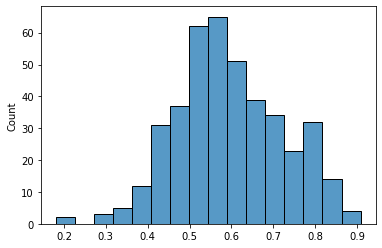

In [90]:
sns.histplot(top_similarities)

In [91]:
sentences[top_similarities < 0.2]

array(['This prompted us to harvest OSNsand OPCs from adult and embryonic day 15 (E15) MOE, General Characteristics of the Single-Cell Profiles The hybridization of amplified single-cell cDNAs to mi- respectively, to increase the probability of successfully isolating multiple representatives of each cell type.'],
      dtype='<U898')

In [92]:
sentence

'This prompted us to harvest OSNs and OPCs from adult and embryonic day 15 (E15) MOE, respectively, to increase the probability of successfully isolating multiple representatives of each cell type'

In [86]:
len(sentences)

374

In [85]:
top_similarities = distances_to_positives.min(axis=1)
sentences[top_similarities < 0.1]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 374 but corresponding boolean dimension is 208

In [53]:
txt_file.is_file()

True

In [49]:
distances_to_positives

NameError: name 'distances_to_positives' is not defined

# Fine-tune Bio-BERT model to classify sentences

Model: https://huggingface.co/dmis-lab/biobert-large-cased-v1.1-mnli

Tutorial: https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb

In [111]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [96]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1-mnli")

model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-large-cased-v1.1-mnli")

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [98]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [99]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(58996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [104]:
inputs = tokenizer.batch_encode_plus(
    positive_examples,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding="max_length",
    return_token_type_ids=True
)

In [114]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [117]:
inputs["input_ids"][0][:15]

[101,
 1142,
 9249,
 1366,
 1106,
 15390,
 29007,
 2316,
 1105,
 11769,
 6063,
 1121,
 4457,
 1105,
 30770]

In [123]:
inputs["token_type_ids"][0][:50]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [124]:
inputs["attention_mask"][0][:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [113]:
len(inputs["input_ids"])

68

In [100]:
positive_examples

['This prompted us to harvest OSNs and OPCs from adult and embryonic day 15 (E15) MOE, respectively, to increase the probability of successfully isolating multiple representatives of each cell type',
 'We mapped approximately 700\u2009million sequencing reads derived from 33\u2009single cells of multiple stages, ranging from mature oocytes to 8-cell blastomeres. To control the quality of single-cell RNA-seq from technical errors, we focused on libraries (26\u2009out of a total 33,\u2009or 79%) that share at least 80% similarity with other libraries derived from identical pre-implantation stages (Supplementary Table 1). ',
 'To analyze intratumoral heterogeneity systematically, we isolated individual cells from five freshly resected and dissociated human glioblastomas and generated single-cell full-length transcriptomes using SMART-seq (96 to 192 cells per tumor, total 672 cells; Fig. 1A).',
 'By capturing 301 single cells from 11 populations using microfluidics and analyzing single-cel

In [ ]:
model(torch.tensor(inputs["input_ids"], dtype=torch.long))